In [16]:
import pandas as pd
import numpy as np

In [19]:
connections = pd.read_csv(
    "../../new_data/connections.csv",
    dtype={"pre_root_id": "string", "post_root_id": "string", "syn_count": np.int32},
)
nc = pd.read_table(
    "../../new_data/neuron_annotations.tsv",
    dtype={
        "root_id": "string",
        "soma_x": np.float32,
        "soma_y": np.float32,
        "soma_z": np.float32,
        "cell_type": "string",
    },
)[["root_id", "soma_x", "soma_y", "soma_z", "cell_type"]]

/tmp/ipykernel_88068/1533153900.py:5: DtypeWarning: Columns (14,15,16,17,23) have mixed types. Specify dtype option on import or set low_memory=False.
  nc = pd.read_table(


In [38]:
def compute_total_synapse_length(connections, nc):

    df = connections.merge(
        nc,
        left_on="pre_root_id",
        right_on="root_id",
        suffixes=("", "_pre"),
    ).merge(
        nc,
        left_on="post_root_id",
        right_on="root_id",
        suffixes=("_pre", "_post"),
    )

    # Drop unneeded columns to free memory
    df = df.drop(columns=["root_id_pre", "root_id_post", "pre_root_id", "post_root_id"])

    # Vectorized distance calculation
    distances = np.sqrt(
        (df["soma_x_pre"] - df["soma_x_post"]) ** 2
        + (df["soma_y_pre"] - df["soma_y_post"]) ** 2
        + (df["soma_z_pre"] - df["soma_z_post"]) ** 2
    )

    # Multiply by synapse counts and sum
    total_length = np.sum(distances * df["syn_count"])

    return total_length

In [39]:
total_length = compute_total_synapse_length(connections, nc)

In [41]:
import numpy as np
import pandas as pd


def shuffle_post_root_id(connections):
    """
    Returns a copy of `connections` where the 'post_root_id' column
    is randomly shuffled, leaving 'pre_root_id' and 'syn_count' intact.
    """
    new_conns = connections.copy()
    # Shuffle post_root_id in place
    shuffled_posts = np.random.permutation(new_conns["post_root_id"].values)
    new_conns["post_root_id"] = shuffled_posts
    return new_conns


def compute_total_synapse_length(connections, nc):
    """
    Computes sum(distance * syn_count) by merging with `nc`.
    connections: DataFrame with columns [pre_root_id, post_root_id, syn_count]
    nc: DataFrame with columns [root_id, soma_x, soma_y, soma_z]
    Returns a float (total wiring length).
    """
    # Merge pre
    df = connections.merge(
        nc,
        left_on="pre_root_id",
        right_on="root_id",
        suffixes=("", "_pre"),
    ).merge(
        nc,
        left_on="post_root_id",
        right_on="root_id",
        suffixes=("_pre", "_post"),
    )

    # Drop unneeded columns
    df = df.drop(columns=["root_id_pre", "root_id_post", "pre_root_id", "post_root_id"])

    # Compute Euclidean distance
    dx = df["soma_x_pre"] - df["soma_x_post"]
    dy = df["soma_y_pre"] - df["soma_y_post"]
    dz = df["soma_z_pre"] - df["soma_z_post"]
    dist = np.sqrt(dx * dx + dy * dy + dz * dz)

    # Weighted sum
    total_length = np.sum(dist * df["syn_count"])
    return total_length


def match_wiring_length_with_syn_scale(
    connections,
    nc,
    real_length,
    scale_low=0.0,
    scale_high=2.0,
    max_iter=5,
    tolerance=0.01,
):
    """
    Iteratively search for a global scale factor s in [scale_low, scale_high]
    such that sum(distance * (syn_count*s)) ~ real_length.

    connections: DataFrame [pre_root_id, post_root_id, syn_count]
    nc         : DataFrame [root_id, soma_x, soma_y, soma_z]
    real_length: Target total wiring length
    scale_low  : initial lower bound on scale
    scale_high : initial upper bound on scale
    max_iter   : max number of binary search iterations
    tolerance  : fraction (or absolute) to decide "close enough"

    Returns the scaled DataFrame. The 'syn_count' column is overwritten
    with the final scaled values.
    """
    # Copy so we don't modify the original DataFrame
    conns_scaled = connections.copy()

    for i in range(max_iter):
        mid = 0.5 * (scale_low + scale_high)

        # Temporarily scale syn_count by mid
        conns_scaled["syn_count"] = connections["syn_count"] * mid
        length_est = compute_total_synapse_length(conns_scaled, nc)

        # Check how close we are
        ratio = length_est / real_length
        print(f"Iter={i}, scale={mid:.4f}, length={length_est:.2f}, ratio={ratio:.3f}")

        # If we're still below the real length, we need a bigger scale
        if length_est < real_length:
            scale_low = mid
        else:
            scale_high = mid

        # If ratio is within ~1 +/- tolerance, we can stop
        if abs(ratio - 1.0) < tolerance:
            break

    # Final scale
    final_scale = 0.5 * (scale_low + scale_high)
    conns_scaled["syn_count"] = connections["syn_count"] * final_scale

    return conns_scaled

# 2) Shuffle the post_root_id to randomize
connections_shuffled = shuffle_post_root_id(connections)

# 3) Use a small binary search to find a global syn_count scale factor
#    that brings the total (dist * syn_count) close to the real_length
scaled_random = match_wiring_length_with_syn_scale(
    connections_shuffled,
    nc,
    total_length,
    scale_low=0.0,
    scale_high=2.0,
    max_iter=10,
    tolerance=0.01,
)

# 4) scaled_random now has syn_count scaled so that total wiring length
#    is in the same ballpark as the real connectome
final_length = compute_total_synapse_length(scaled_random, nc)
print("Final scaled random total length =", final_length)

Iter=0, scale=1.0000, length=3230114862777.60, ratio=2.443
Iter=1, scale=0.5000, length=1615057431388.80, ratio=1.221
Iter=2, scale=0.2500, length=807528715694.40, ratio=0.611
Iter=3, scale=0.3750, length=1211293073541.60, ratio=0.916
Iter=4, scale=0.4375, length=1413175252465.20, ratio=1.069
Iter=5, scale=0.4062, length=1312234163003.40, ratio=0.992
Final scaled random total length = 1362704707734.2942


In [42]:
scaled_random["syn_count"] = np.round(scaled_random["syn_count"]).astype(np.int32)
scaled_random.to_csv("../../new_data/connections_random.csv", index=False)

In [22]:
import math
import numpy as np
from numba import njit


@njit
def euclidean_distance_3d(a, b):
    dx = a[0] - b[0]
    dy = a[1] - b[1]
    dz = a[2] - b[2]
    return math.sqrt(dx * dx + dy * dy + dz * dz)


@njit
def generate_random_edges_chunk(positions, edges_needed, alpha):
    """
    Generate `edges_needed` random edges with acceptance probability
    exp(-alpha * distance). Return an int64 array of shape (edges_needed, 2).
    Uses np.random.random() inside Numba (no explicit seed).
    """
    N = positions.shape[0]

    # We'll store accepted edges in a fixed-size array
    edges_out = np.empty((edges_needed, 2), dtype=np.int64)

    accepted = 0
    while accepted < edges_needed:
        # random pre, post in [0, N), cast to int
        i = int(np.random.random() * N)
        j = int(np.random.random() * N)
        if i == j:
            # skip self-connections
            continue

        dist = euclidean_distance_3d(positions[i], positions[j])

        # accept with probability exp(-alpha * dist)
        if np.random.random() < math.exp(-alpha * dist):
            edges_out[accepted, 0] = i
            edges_out[accepted, 1] = j
            accepted += 1

    return edges_out

In [23]:
import math
import numpy as np
import multiprocessing
from tqdm import tqdm


@njit
def euclidean_distance_3d(a, b):
    dx = a[0] - b[0]
    dy = a[1] - b[1]
    dz = a[2] - b[2]
    return math.sqrt(dx * dx + dy * dy + dz * dz)


@njit
def generate_random_edges_chunk(positions, edges_needed, alpha):
    """
    Generate `edges_needed` random edges with acceptance probability
    exp(-alpha * distance). Return an int64 array of shape (edges_needed, 2).
    Uses np.random.random() inside Numba (no explicit seed).
    """
    N = positions.shape[0]

    # We'll store accepted edges in a fixed-size array
    edges_out = np.empty((edges_needed, 2), dtype=np.int64)

    accepted = 0
    while accepted < edges_needed:
        # random pre, post in [0, N), cast to int
        i = int(np.random.random() * N)
        j = int(np.random.random() * N)
        if i == j:
            # skip self-connections
            continue

        dist = euclidean_distance_3d(positions[i], positions[j])

        # accept with probability exp(-alpha * dist)
        if np.random.random() < math.exp(-alpha * dist):
            edges_out[accepted, 0] = i
            edges_out[accepted, 1] = j
            accepted += 1

    return edges_out


def parallel_generate_random_edges(positions, total_edges, alpha, num_workers=4):
    """
    Generate `total_edges` edges in parallel with distance-bias factor alpha.
    Show a tqdm progress bar that increments when each worker finishes.
    """
    chunk_size = total_edges // num_workers
    rema = total_edges % num_workers

    # We'll store results in a global list so we can receive them in the callback
    manager = multiprocessing.Manager()
    shared_results = manager.list()  # safe to modify in callback

    # Create a function that will be called back when each worker finishes
    def on_worker_done(result):
        # 'result' is the array returned by generate_random_edges_chunk
        shared_results.append(result)
        pbar.update(1)  # increment progress bar by 1 chunk

    pool = multiprocessing.Pool(num_workers)

    # We'll have a progress bar that counts how many chunks are done
    total_chunks = num_workers  # we have exactly one chunk per worker
    with tqdm(total=total_chunks, desc="Generating edges") as pbar:
        # Launch each worker
        for w in range(num_workers):
            this_chunk = chunk_size + (1 if w < rema else 0)
            if this_chunk == 0:
                continue
            # Note we call apply_async, passing on_worker_done as callback
            pool.apply_async(
                generate_random_edges_chunk,
                args=(positions, this_chunk, alpha),
                callback=on_worker_done,  # executed in the main process
            )

        # Close the pool to new tasks and wait for them to finish
        pool.close()
        pool.join()

    # At this point, shared_results contains all chunk arrays
    all_arrays = list(shared_results)
    return np.vstack(all_arrays)

In [35]:
np.random.seed(123)

print("Generating edges in parallel...")
alpha = 7.5e-4
edges = parallel_generate_random_edges(
    nc[["soma_x", "soma_y", "soma_z"]].values,
    connections.shape[0],
    alpha,
    num_workers=multiprocessing.cpu_count() - 2,
)
print(f"Created {edges.shape[0]} edges: shape={edges.shape}")

Generating edges in parallel...


Generating edges: 100%|██████████| 14/14 [07:53<00:00, 33.80s/it]  


Created 16847997 edges: shape=(16847997, 2)


In [36]:
positions = nc[["soma_x", "soma_y", "soma_z"]].values  # shape (N, 3)
# edges is shape (M, 2) with each element an index into positions


def compute_wiring_length(positions, edges, syn_counts):
    """
    positions: (N,3) array with [x, y, z] for each neuron
    edges: (M,2) array of int indices
    syn_counts: (M,) array of syn_count for each edge
    Returns sum of (distance * syn_count).
    """
    diffs = positions[edges[:, 0]] - positions[edges[:, 1]]
    dists = np.sqrt(np.sum(diffs * diffs, axis=1))
    # remove missing data
    dists = dists[~np.isnan(dists)]
    # Weighted by syn_count
    total_length = np.sum(dists * syn_counts)
    return total_length


# Then:
total_len = compute_wiring_length(positions, edges, connections["syn_count"].values)
print("Total random connectome wiring length =", total_len)

Total random connectome wiring length = 155190186046.09686


In [20]:
import numpy as np

# Suppose 'nc' has columns: ['root_id', 'soma_x', 'soma_y', 'soma_z', 'cell_type']
# The KCs are those rows where cell_type is in ["KCapbp-m", "KCapbp-ap2", "KCapbp-ap1"]

kcs_mask = nc["cell_type"].isin(["KCapbp-m", "KCapbp-ap2", "KCapbp-ap1"])
kcs_indices = np.where(kcs_mask)[0]  # 0-based row indices
print(f"Number of Kenyon cells in nc: {len(kcs_indices)}")

Number of Kenyon cells in nc: 916


In [26]:
N = len(nc)  # number of total neurons in nc
M = edges.shape[0]  # number of edges
print("Random edges shape:", edges.shape)

# Check any out-of-range pre or post
invalid_pre = np.sum((edges[:, 0] < 0) | (edges[:, 0] >= N))
invalid_post = np.sum((edges[:, 1] < 0) | (edges[:, 1] >= N))

print(f"Invalid pre indices: {invalid_pre}, invalid post indices: {invalid_post}")

Random edges shape: (16847997, 2)
Invalid pre indices: 0, invalid post indices: 0


In [27]:
num_inbound_to_kcs = np.isin(edges[:, 1], kcs_indices).sum()
print(f"Number of inbound edges to Kenyon cells: {num_inbound_to_kcs}")

Number of inbound edges to Kenyon cells: 87992


In [37]:
import pandas as pd
import numpy as np
import math
import multiprocessing
from tqdm import tqdm
from numba import njit

# Suppose you already have:
#   nc: a DataFrame with columns [root_id, soma_x, soma_y, soma_z]
#   connections: a DataFrame with columns [pre_root_id, post_root_id, syn_count]
#   edges: an array of shape (M, 2) generated by our random code
#          edges[i,0] = index_in_nc_of_pre
#          edges[i,1] = index_in_nc_of_post
#   random_syn_counts: an array of shape (M,) with the syn_count for each random edge

# Step 1: Make sure you have a quick way to map from row-index to root_id.
# The easiest is:  root_id_for_index = nc["root_id"].values
root_id_for_index = nc["root_id"].values  # shape = (N,)

# Step 2: For the random edges (pre_idx, post_idx), convert them into the actual root IDs.
pre_root_ids = root_id_for_index[edges[:, 0]]
post_root_ids = root_id_for_index[edges[:, 1]]

# Step 3: Assemble a DataFrame with the same structure as 'connections'.
random_connections = pd.DataFrame(
    {
        "pre_root_id": pre_root_ids,
        "post_root_id": post_root_ids,
        "syn_count": connections["syn_count"].values
    }
)

# Step 4: Write out to CSV (no index column).
random_connections.to_csv("../../new_data/connections_random.csv", index=False)

print("Wrote random connections to connections_random.csv")
print("Shape:", random_connections.shape)
print(random_connections.head())

Wrote random connections to connections_random.csv
Shape: (16847997, 3)
          pre_root_id        post_root_id  syn_count
0  720575940626719013  720575940619116885          7
1  720575940638305853  720575940640688336          4
2  720575940628955691  720575940614281523          2
3  720575940614219670  720575940616951947          2
4  720575940647944500  720575940618273826         15


In [29]:
aaa = pd.read_csv("../../new_data/connections_random.csv")

In [30]:
bbb = pd.read_csv("../../new_data/connections.csv")

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns


def compute_random_lengths(
    connections: pd.DataFrame, nc: pd.DataFrame, n_iterations: int = 100
) -> list:
    """
    Compute total synapse length for n random permutations of the connectome
    and compare with real length.

    Args:
        connections: DataFrame with synaptic connections
        nc: DataFrame with neuron coordinates
        n_iterations: Number of random permutations to generate

    Returns:
        list: list of random lengths
    """

    # Store random lengths
    random_lengths = []

    # For each iteration, shuffle post_root_ids and compute length
    for _ in tqdm(range(n_iterations), desc="Generating random connectomes"):
        # Create a copy with shuffled post_root_ids
        random_connections = connections.copy()
        random_connections["post_root_id"] = np.random.permutation(
            random_connections["post_root_id"].values
        )

        # Compute length for this random version
        random_length = compute_total_synapse_length(random_connections, nc)
        random_lengths.append(random_length)

    return random_lengths


def plot_length_comparison(real_length: float, random_lengths: list):
    """
    Create a histogram of random lengths with the real length marked.
    """
    plt.figure(figsize=(10, 6))

    # Plot histogram of random lengths
    sns.histplot(random_lengths, bins=30, alpha=0.6)

    # Add vertical line for real length
    plt.axvline(
        x=real_length,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Real length: {real_length:,.0f}",
    )

    # Calculate and display statistics
    mean_random = np.mean(random_lengths)
    std_random = np.std(random_lengths)
    z_score = (real_length - mean_random) / std_random

    plt.title(
        "Distribution of Random Connectome Lengths\n"
        + f"Z-score of real length: {z_score:.2f}"
    )
    plt.xlabel("Total Synapse Length")
    plt.ylabel("Count")
    plt.legend()

    # Add text with statistics
    plt.text(
        0.02,
        0.98,
        f"Random mean: {mean_random:,.0f}\n" + f"Random std: {std_random:,.0f}",
        transform=plt.gca().transAxes,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
    )

    plt.tight_layout()
    return plt.gcf()



In [16]:
random_lengths = compute_random_lengths(
    connections, nc, n_iterations=500
)

# Create and save plot
fig = plot_length_comparison(total_length, random_lengths)
fig.savefig("connectome_length_comparison.pdf", dpi=300, bbox_inches="tight")
plt.close()

# Print summary statistics
print(f"\nReal length: {total_length:,.0f}")
print(f"Mean random length: {np.mean(random_lengths):,.0f}")
print(f"Std random length: {np.std(random_lengths):,.0f}")
print(
    f"Z-score of real length: {(total_length - np.mean(random_lengths)) / np.std(random_lengths):.2f}"
)

Generating random connectomes: 100%|██████████| 500/500 [2:38:25<00:00, 19.01s/it]  



Real length: 1,322,450,938,675
Mean random length: 3,230,452,785,893
Std random length: 1,063,129,484
Z-score of real length: -1794.70


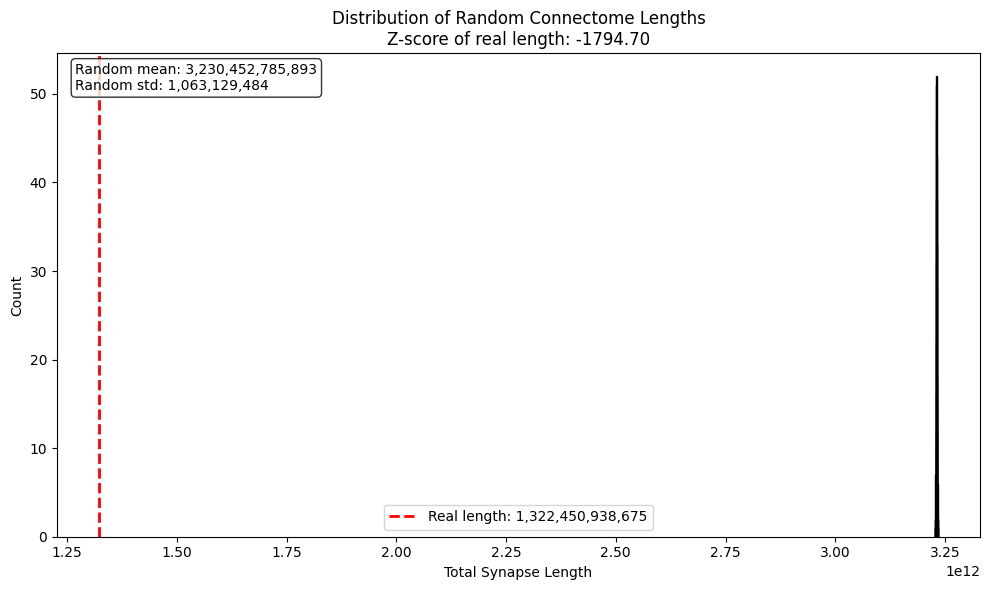

In [27]:
fig = plot_length_comparison(total_length, random_lengths)
plt.show()

# Trying to have smaller wiring lengths when shuffling

In [8]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


def get_distance_bins(distances: np.ndarray, n_bins: int) -> np.ndarray:
    """Compute bin edges for valid distances"""
    valid_distances = distances[np.isfinite(distances)]
    if len(valid_distances) == 0:
        return None
    try:
        return np.histogram_bin_edges(valid_distances, bins=n_bins)
    except ValueError:
        return None


def process_neuron_chunk(
    pre_ids: np.ndarray,
    coords_dict: dict,
    valid_post_ids: np.ndarray,
    n_bins: int,
    chunk_size: int = 10000,
) -> dict:
    """Process a chunk of pre-synaptic neurons to create distance bins"""
    binned_candidates = {}

    # Process neurons in smaller chunks
    for i in tqdm(range(0, len(pre_ids), chunk_size), desc="Processing neuron chunk"):
        chunk_pre_ids = pre_ids[i : i + chunk_size]

        for pre_id in chunk_pre_ids:
            if pre_id not in coords_dict:
                continue

            pre_coords = coords_dict[pre_id]

            # Calculate distances to all valid post neurons
            distances = np.array(
                [
                    np.sqrt(np.sum((coords_dict[post_id] - pre_coords) ** 2))
                    for post_id in valid_post_ids
                    if post_id in coords_dict
                ]
            )

            bins = get_distance_bins(distances, n_bins)
            if bins is None:
                continue

            # Store valid post neurons in each bin
            binned_candidates[pre_id] = {
                i: valid_post_ids[(distances >= bins[i]) & (distances < bins[i + 1])]
                for i in range(len(bins) - 1)
            }

            del distances

    return binned_candidates


def compute_distance_preserved_random_lengths(
    connections: pd.DataFrame,
    nc: pd.DataFrame,
    n_iterations: int = 10,
    n_bins: int = 10,
    chunk_size: int = 10000,
) -> tuple:
    """
    Compute total synapse length for n random permutations of the connectome,
    processing in chunks to manage memory usage.
    """
    # Pre-filter to valid neurons and create coordinate dictionary
    valid_nc = nc.dropna(subset=["soma_x", "soma_y", "soma_z"])
    coords_dict = dict(
        zip(valid_nc["root_id"], valid_nc[["soma_x", "soma_y", "soma_z"]].values)
    )

    valid_neurons = set(coords_dict.keys())
    valid_connections = connections[
        connections["pre_root_id"].isin(valid_neurons)
        & connections["post_root_id"].isin(valid_neurons)
    ]

    # Compute real length
    real_length = compute_total_synapse_length(valid_connections, valid_nc)
    print(f"Real length computed: {real_length:,.0f}")

    # Get unique pre and post neurons
    pre_neurons = valid_connections["pre_root_id"].unique()
    valid_post_ids = valid_connections["post_root_id"].unique()

    # Process pre-synaptic neurons in chunks
    print("Creating distance-binned candidates...")
    binned_candidates = {}
    for i in tqdm(range(0, len(pre_neurons), chunk_size)):
        chunk_binned = process_neuron_chunk(
            pre_neurons[i : i + chunk_size],
            coords_dict,
            valid_post_ids,
            n_bins,
            chunk_size=chunk_size,
        )
        binned_candidates.update(chunk_binned)

    # Free memory
    del coords_dict

    random_lengths = []
    print("Generating random connectomes...")

    # Process random connectomes in chunks
    for iter_num in tqdm(range(n_iterations)):
        random_length = 0

        # Process connections in chunks
        for i in tqdm(range(0, len(valid_connections), chunk_size), desc=f"Iteration {iter_num}"):
            chunk_connections = valid_connections.iloc[i : i + chunk_size].copy()

            # Randomize this chunk
            for pre_id in chunk_connections["pre_root_id"].unique():
                if pre_id not in binned_candidates:
                    continue

                mask = chunk_connections["pre_root_id"] == pre_id
                for idx in chunk_connections[mask].index:
                    # Choose random bin and post-synaptic neuron
                    valid_bins = [
                        b
                        for b in binned_candidates[pre_id].keys()
                        if len(binned_candidates[pre_id][b]) > 0
                    ]
                    if valid_bins:
                        chosen_bin = np.random.choice(valid_bins)
                        chunk_connections.loc[idx, "post_root_id"] = np.random.choice(
                            binned_candidates[pre_id][chosen_bin]
                        )

            # Compute length for this chunk
            chunk_length = compute_total_synapse_length(chunk_connections, valid_nc)
            random_length += chunk_length

            del chunk_connections

        random_lengths.append(random_length)

    return real_length, random_lengths


def plot_length_comparison(real_length: float, random_lengths: list):
    """Create histogram plot comparing lengths"""
    plt.figure(figsize=(10, 6))

    sns.histplot(random_lengths, bins=30, alpha=0.6)
    plt.axvline(
        x=real_length,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Real length: {real_length:,.0f}",
    )

    mean_random = np.mean(random_lengths)
    std_random = np.std(random_lengths)
    z_score = (real_length - mean_random) / std_random

    plt.title(
        "Distribution of Distance-Preserved Random Connectome Lengths\n"
        + f"Z-score of real length: {z_score:.2f}"
    )
    plt.xlabel("Total Synapse Length")
    plt.ylabel("Count")
    plt.legend()

    plt.text(
        0.02,
        0.98,
        f"Random mean: {mean_random:,.0f}\n" + f"Random std: {std_random:,.0f}",
        transform=plt.gca().transAxes,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
    )

    plt.tight_layout()
    return plt.gcf()

In [9]:
    # Compute real and random lengths
real_length, random_lengths = compute_distance_preserved_random_lengths(
    connections, nc, n_iterations=10, n_bins=10
)

# Create and save plot
fig = plot_length_comparison(real_length, random_lengths)
fig.savefig(
    "connectome_length_comparison_distance_preserved.pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.close()

# Print summary statistics
print(f"\nReal length: {real_length:,.0f}")
print(f"Mean random length: {np.mean(random_lengths):,.0f}")
print(f"Std random length: {np.std(random_lengths):,.0f}")
print(
    f"Z-score of real length: {(real_length - np.mean(random_lengths)) / np.std(random_lengths):.2f}"
)

Real length computed: 1,322,450,938,675
Creating distance-binned candidates...


  0%|          | 0/12 [41:35<?, ?it/s]


KeyboardInterrupt: 